In [1]:
import scipy
#import pytrends
#from pytrends.request import TrendReq
from numpy import random
import matplotlib.pyplot as plt
from scipy import optimize
import sys
import time
import pandas as pd
import seaborn as sns
import numpy as np
from pandas.io.json import json_normalize
import json
from datetime import datetime, timedelta
from county_spending import get_county_spending, spend_county_state_map, us_state_abbrev, abbrev_us_state
from ACS_data import colname_mask
import re
import pickle

pd.set_option('display.max_columns', None)

In [2]:

import censusdata
censusdata.censusgeo([('county','*')])

incomeACS = censusdata.download('acs1',2019,censusdata.censusgeo([('state','*'),('county','*')]), ['DP03_0062E'], tabletype='profile')

incomeACS.columns=['median household income']
incomeACS.to_csv(r'incomeACS.csv')

In [3]:
newacs = pd.read_csv("newACS.csv", index_col=0)
newacs['county_name'] = [newacs.index[x].split(",")[0] for x in range(len(newacs.index))]
newacs['State'] = [newacs.index[x].split(",")[1].split(":")[0][1:] for x in range(len(newacs.index))]
newacs['State'] = newacs['State'].apply(lambda x: us_state_abbrev[x] if x in us_state_abbrev.keys() else x)
newacs['tot'] = 0
newacs['id'] = 0
newacs.head()


,employed people with 16 yrs and over,unemployed people with 16 yrs and over,people in the labor force,unemployment rate,people with private health insurance,people with public health insurance,people without health insurance,people with a disability,male,female,people that are older than 65,median household income,median age,county_name,State,tot,id
"Fayette County, Illinois: Summary level: 050, state:17> county:051",8760,525,9285,5.7,11692,9395,1644,3527.0,11469,10096,4058,46650,41.9,Fayette County,IL,0,0
"Logan County, Illinois: Summary level: 050, state:17> county:107",12426,738,13164,5.6,19106,9777,1154,3917.0,14298,14705,5224,57308,40.1,Logan County,IL,0,0
"Saline County, Illinois: Summary level: 050, state:17> county:165",9902,816,10718,7.6,14218,12485,993,5240.0,11807,12187,4785,44090,42.2,Saline County,IL,0,0
"Lake County, Illinois: Summary level: 050, state:17> county:097",351926,19357,371283,5.2,519407,186251,46304,62508.0,350466,351007,96339,89427,38.4,Lake County,IL,0,0
"Massac County, Illinois: Summary level: 050, state:17> county:127",5636,259,5895,4.4,8251,6813,752,2892.0,6714,7505,2962,47481,43.5,Massac County,IL,0,0


In [4]:
covid_cases = pd.read_csv('covid_confirmed_usafacts.csv')
covid_cases = covid_cases.rename(columns={'County Name':'county_name'})
covid_cases['county_name'] = covid_cases['county_name'].apply(lambda x: x.strip())
covid_cases.head()

# only cumulative
covid_cases = covid_cases[['countyFIPS','county_name','State','StateFIPS','2021-03-21']]



In [5]:
county_spending = get_county_spending()
county_spending = county_spending.rename(columns={'display_name':'county_name'})
county_spending['county_name'] = county_spending['county_name'].fillna('Missing')
county_spending['county_name'] = county_spending['county_name'].apply(lambda x: x + ' County')
county_spending = spend_county_state_map(county_spending, newacs, covid_cases)
county_spending['State'] = county_spending['State'].apply(lambda x: us_state_abbrev[x] if x in us_state_abbrev.keys() else x)

county_spending['log population'] = np.log(county_spending['population'])
county_spending['log amount'] = np.log(county_spending['amount'])
county_spending.head()

,amount,award_count,county_name,per_capita,population,shape_code,State,log population,log amount
0,3.723723e+10,801768,Los Angeles County,3709.22,10039107.0,06037,CA,16.121999,24.340575
1,1.025893e+10,449514,Miami-Dade County,3775.91,2716940.0,12086,FL,14.815017,23.051415
2,2.933606e+10,440443,Cook County,5696.06,5150233.0,17031,GA,15.454553,24.102083
3,1.506909e+10,302029,Harris County,3197.13,4713325.0,48201,GA,15.365904,23.435912
4,7.473692e+09,244146,Broward County,3827.21,1952778.0,12011,FL,14.484764,22.734655


In [6]:
data = county_spending.dropna()
missing= len(county_spending.index) - len(data.index)
print("Number of missing vals: ", missing," - ", 100*missing/len(county_spending.index),"% of total")

Number of missing vals:  93  -  2.87569573283859 % of total


In [7]:
import os
#os.dir()
os.chdir("/home/marylena/Documents/ConsultingProject")
print("finished chdir")
business = pd.read_csv("BusinessByCounty.csv", index_col=0).drop(index="id")
print("finished reading data, lenght", len(business.index))
business = business.iloc[np.where(business['NAICS2017_LABEL']=="Total for all sectors")[0],:]
business= business.iloc[np.where(business['LFO_LABEL']=="All establishments")[0],:]
business = business.iloc[np.where(business['EMPSZES_LABEL']=="All establishments")]
print("finished dropping, length",len(business.index))
business.head()


finished chdir


/home/marylena/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1,5,6,7,8,9,10,12,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


finished reading data, lenght 227294
finished dropping, length 3245


,GEO_ID_F,NAME,NAICS2017,NAICS2017_LABEL,SECTOR,NAICS2017_F,SUBSECTOR,INDLEVEL,INDGROUP,LFO,LFO_LABEL,EMPSZES,EMPSZES_LABEL,YEAR,ESTAB,PAYANN,PAYANN_N,PAYQTR1,PAYQTR1_N,EMP,EMP_N
GEO_ID,,,,,,,,,,,,,,,,,,,,,
0500000US01001,NaN,"Autauga County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,855,373865,G,90886,G,11397,G
0500000US01003,NaN,"Baldwin County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,5507,2212640,G,517512,G,64354,G
0500000US01005,NaN,"Barbour County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,461,248131,G,60192,G,6980,G
0500000US01007,NaN,"Bibb County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,293,145171,H,35475,H,3519,G
0500000US01009,NaN,"Blount County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,706,219763,G,52252,G,6673,G


In [8]:
business['county_name'] = [business.NAME[x].split(",")[0] for x in range(len(business.index))]
print("finished county name")
business['State'] =  [business.NAME[x].split(",")[len(business.NAME[x].split(","))-1][1:] for x in range(len(business.index))]
print("finished State 1")


business.head()

finished county name
finished State 1


,GEO_ID_F,NAME,NAICS2017,NAICS2017_LABEL,SECTOR,NAICS2017_F,SUBSECTOR,INDLEVEL,INDGROUP,LFO,LFO_LABEL,EMPSZES,EMPSZES_LABEL,YEAR,ESTAB,PAYANN,PAYANN_N,PAYQTR1,PAYQTR1_N,EMP,EMP_N,county_name,State
GEO_ID,,,,,,,,,,,,,,,,,,,,,,,
0500000US01001,NaN,"Autauga County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,855,373865,G,90886,G,11397,G,Autauga County,Alabama
0500000US01003,NaN,"Baldwin County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,5507,2212640,G,517512,G,64354,G,Baldwin County,Alabama
0500000US01005,NaN,"Barbour County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,461,248131,G,60192,G,6980,G,Barbour County,Alabama
0500000US01007,NaN,"Bibb County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,293,145171,H,35475,H,3519,G,Bibb County,Alabama
0500000US01009,NaN,"Blount County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,706,219763,G,52252,G,6673,G,Blount County,Alabama


In [9]:
business['State'] = business['State'].apply(lambda x: us_state_abbrev[x] if x in us_state_abbrev.keys() else x)
print("finished State 2")
business.head()

finished State 2


,GEO_ID_F,NAME,NAICS2017,NAICS2017_LABEL,SECTOR,NAICS2017_F,SUBSECTOR,INDLEVEL,INDGROUP,LFO,LFO_LABEL,EMPSZES,EMPSZES_LABEL,YEAR,ESTAB,PAYANN,PAYANN_N,PAYQTR1,PAYQTR1_N,EMP,EMP_N,county_name,State
GEO_ID,,,,,,,,,,,,,,,,,,,,,,,
0500000US01001,NaN,"Autauga County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,855,373865,G,90886,G,11397,G,Autauga County,AL
0500000US01003,NaN,"Baldwin County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,5507,2212640,G,517512,G,64354,G,Baldwin County,AL
0500000US01005,NaN,"Barbour County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,461,248131,G,60192,G,6980,G,Barbour County,AL
0500000US01007,NaN,"Bibb County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,293,145171,H,35475,H,3519,G,Bibb County,AL
0500000US01009,NaN,"Blount County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,706,219763,G,52252,G,6673,G,Blount County,AL


In [10]:
newacs.head()

,employed people with 16 yrs and over,unemployed people with 16 yrs and over,people in the labor force,unemployment rate,people with private health insurance,people with public health insurance,people without health insurance,people with a disability,male,female,people that are older than 65,median household income,median age,county_name,State,tot,id
"Fayette County, Illinois: Summary level: 050, state:17> county:051",8760,525,9285,5.7,11692,9395,1644,3527.0,11469,10096,4058,46650,41.9,Fayette County,IL,0,0
"Logan County, Illinois: Summary level: 050, state:17> county:107",12426,738,13164,5.6,19106,9777,1154,3917.0,14298,14705,5224,57308,40.1,Logan County,IL,0,0
"Saline County, Illinois: Summary level: 050, state:17> county:165",9902,816,10718,7.6,14218,12485,993,5240.0,11807,12187,4785,44090,42.2,Saline County,IL,0,0
"Lake County, Illinois: Summary level: 050, state:17> county:097",351926,19357,371283,5.2,519407,186251,46304,62508.0,350466,351007,96339,89427,38.4,Lake County,IL,0,0
"Massac County, Illinois: Summary level: 050, state:17> county:127",5636,259,5895,4.4,8251,6813,752,2892.0,6714,7505,2962,47481,43.5,Massac County,IL,0,0


In [11]:
acs_nodupe= newacs.drop_duplicates(subset=['county_name','State'], keep=False)
data_nodupe=data.drop_duplicates(subset=['county_name','State'], keep=False)
df= business.merge(data, how="left", on=["county_name","State"])
#.merge(acs_nodupe.loc[:,'median household income'], how='left', on=['county_name', 'State'])
acs_nodupe.index=range(len(acs_nodupe.State))
newdf=df.merge(acs_nodupe, how='left', on=['county_name', 'State'])
newdf.head()

,GEO_ID_F,NAME,NAICS2017,NAICS2017_LABEL,SECTOR,NAICS2017_F,SUBSECTOR,INDLEVEL,INDGROUP,LFO,LFO_LABEL,EMPSZES,EMPSZES_LABEL,YEAR,ESTAB,PAYANN,PAYANN_N,PAYQTR1,PAYQTR1_N,EMP,EMP_N,county_name,State,amount,award_count,per_capita,population,shape_code,log population,log amount,employed people with 16 yrs and over,unemployed people with 16 yrs and over,people in the labor force,unemployment rate,people with private health insurance,people with public health insurance,people without health insurance,people with a disability,male,female,people that are older than 65,median household income,median age,tot,id
0,NaN,"Autauga County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,855,373865,G,90886,G,11397,G,Autauga County,AL,16768204.62,1325.0,300.13,55869.0,01001,10.930765,16.634995,24522.0,936.0,25458.0,3.7,38855.0,19242.0,3856.0,10363.0,26934.0,28446.0,8283.0,58731.0,38.2,0.0,0.0
1,NaN,"Baldwin County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,5507,2212640,G,517512,G,64354,G,Baldwin County,AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95091.0,4226.0,99317.0,4.3,148438.0,76905.0,18679.0,29935.0,103496.0,109334.0,42531.0,58320.0,43.0,0.0,0.0
2,NaN,"Barbour County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,461,248131,G,60192,G,6980,G,Barbour County,AL,27453945.06,634.0,1669.85,16441.0,54001,9.707533,17.128020,8413.0,849.0,9262.0,9.2,11916.0,11575.0,2544.0,4806.0,13421.0,11940.0,4710.0,32525.0,40.4,0.0,0.0
3,NaN,"Barbour County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,461,248131,G,60192,G,6980,G,Barbour County,AL,3666709.82,324.0,148.53,24686.0,01005,10.113992,15.114805,8413.0,849.0,9262.0,9.2,11916.0,11575.0,2544.0,4806.0,13421.0,11940.0,4710.0,32525.0,40.4,0.0,0.0
4,NaN,"Bibb County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,293,145171,H,35475,H,3519,G,Bibb County,AL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8387.0,659.0,9046.0,7.3,12491.0,8384.0,2201.0,3559.0,12150.0,10343.0,3584.0,47542.0,40.9,0.0,0.0


In [12]:

#df= business.merge(data, how="left", on=["county_name","State"])
data=newdf.loc[:,["log population", "log amount", "ESTAB","PAYANN", 'median household income']].dropna()
data['log median income'] = np.log(data['median household income'])
#data.index=newdf['county_name']
print(len(data.index))
data.head()

2968


,log population,log amount,ESTAB,PAYANN,median household income,log median income
0,10.930765,16.634995,855,373865,58731.0,10.980723
2,9.707533,17.128020,461,248131,32525.0,10.389764
3,10.113992,15.114805,461,248131,32525.0,10.389764
5,11.798766,18.992145,706,219763,49358.0,10.806855
6,10.965194,17.100038,706,219763,49358.0,10.806855


# Analysis

Avg prediction error:  0.879659149563838


(array([  21.,    0.,    0.,    0.,    0., 2928.,    0.,    0.,    0.,
          19.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

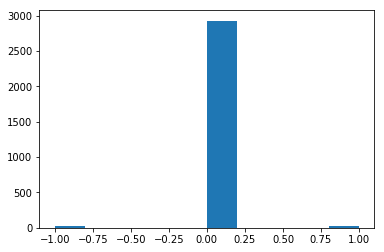

In [13]:
from sklearn import linear_model

y = np.asarray(data['log amount']).reshape(-1,1)
x=np.asarray(data['log population']).reshape(-1,1)

model = linear_model.LinearRegression().fit(x, y)

yhat = model.predict(x)
pred_error = np.sqrt(np.mean(np.subtract(yhat, y)**2))
print("Avg prediction error: ", pred_error)

outlying = np.zeros((len(data.index)))

for i in range(len(data.index)):
    #print(i)
    #print(data.iloc[i,:], "yhat: ",yhat[i])
    #print(y[i])
    if y[i]>= yhat[i] + 3*pred_error:
        outlying[i] = 1
    elif y[i]< yhat[i]-3*pred_error:
        outlying[i]=-1

plt.hist(outlying)

Text(0, 0.5, 'log amount')

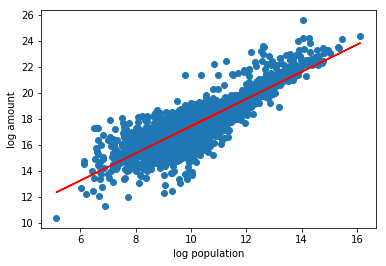

In [14]:
from matplotlib import pyplot as plt



plt.scatter('log population','log amount', data=data)
plt.plot(x, yhat, 'k-', color = 'r')
plt.xlabel('log population')
plt.ylabel('log amount')

In [15]:
print(len(data.index), len(outlying[outlying==-1]))

2968 21


In [16]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data['ESTAB']=data.ESTAB.astype("int64")
data['PAYANN'] = data.PAYANN.astype("int64")
data['logESTAB'] = min_max_scaler.fit_transform(np.asarray(np.log(data.ESTAB)).reshape(-1,1))
data['logPAYANN'] = min_max_scaler.fit_transform(np.asarray(np.log(data.PAYANN)).reshape(-1,1))
data['logESTABlogPAYANN'] = np.log(np.abs(data['logPAYANN']/(data.logESTAB+.001))+.001)
data['logmedincome'] =  min_max_scaler.fit_transform(np.asarray(np.log(data['median household income'])).reshape(-1,1))


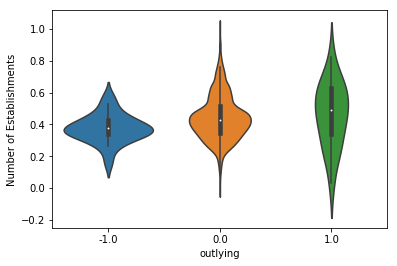

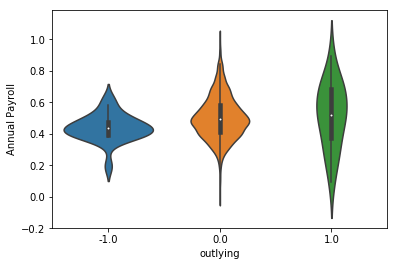

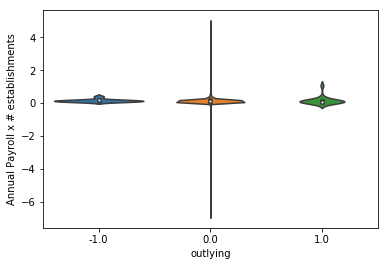

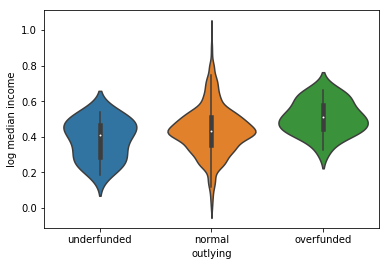

In [17]:
import seaborn as sns

data['outlying'] = outlying
sns.violinplot(x="outlying", y="logESTAB", data=data)
plt.ylabel("Number of Establishments")
plt.show()
sns.violinplot(x="outlying", y="logPAYANN", data=data)
plt.ylabel("Annual Payroll")
plt.show()
sns.violinplot(x="outlying", y="logESTABlogPAYANN", data=data)
plt.ylabel("Annual Payroll x # establishments")
plt.show()
ax = sns.violinplot(x="outlying", y="logmedincome", data=data)
ax.set_xticklabels(['underfunded','normal','overfunded'])
plt.ylabel("log median income")
plt.show()

In [18]:
np.std(np.log(data.logmedincome[np.abs(data.outlying)==1]))

0.29386029830298177

In [19]:
np.std(np.log(data.logmedincome[np.abs(data.outlying)==0]+.0001))

0.43897914664535087

In [20]:
data['log population'].cor(data['log median income'])

AttributeError: 'Series' object has no attribute 'cor'

In [21]:
x_pop=np.asarray(data[['log population']])
x_pop.shape

(2968, 1)

In [22]:
y = np.asarray(data['log amount']).reshape(-1,1)


model = linear_model.LinearRegression().fit(x_pop, y)

yhat = model.predict(x_pop)
pred_error = np.sqrt(np.mean(np.subtract(yhat, y)**2))
print("Avg prediction error: ", pred_error)

Avg prediction error:  0.879659149563838


Text(0, 0.5, 'log amount')

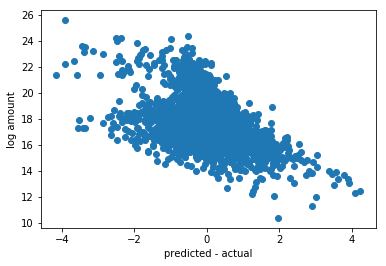

In [23]:
plt.scatter(np.subtract(yhat, y), data['log amount'])
plt.xlabel('predicted - actual')
plt.ylabel('log amount')

Text(0, 0.5, 'log median income')

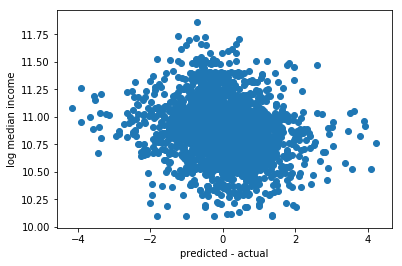

In [24]:
plt.scatter(np.subtract(yhat, y), data['log median income'])
plt.xlabel('predicted - actual')
plt.ylabel('log median income')

In [25]:
x_pop_inc=np.asarray(data[['log population','log median income']])
x_pop_inc.shape

(2968, 2)

In [26]:
y.shape

(2968, 1)

In [27]:
y = np.asarray(data['log amount']).reshape(-1,1)


model2 = linear_model.LinearRegression().fit(x_pop_inc, y)

yhat2 = model2.predict(x_pop_inc)
pred_error2 = np.sqrt(np.mean(np.subtract(yhat2, y)**2))
print("Avg prediction error: ", pred_error2)

Avg prediction error:  0.8643925367103361


Text(0, 0.5, 'log amount')

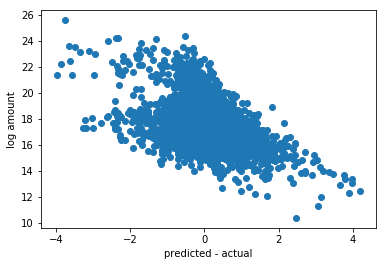

In [28]:
plt.scatter(np.subtract(yhat2, y), data['log amount'])
plt.xlabel('predicted - actual')
plt.ylabel('log amount')

In [29]:
from sklearn import feature_selection

mod = feature_selection.f_regression(x_pop_inc, y)

/home/marylena/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
mod

(array([9258.74625944,  374.89559138]),
 array([0.00000000e+00, 9.56684846e-79]))

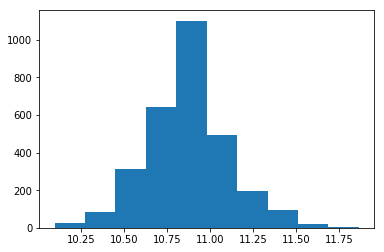

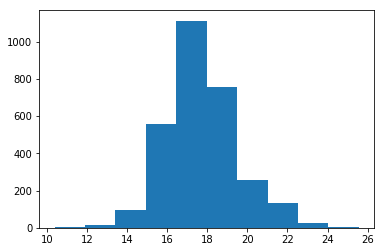

In [31]:
plt.hist(data['log median income'])
plt.show()
plt.hist(y)
plt.show()

Text(0, 0.5, 'log (funding per capita)')

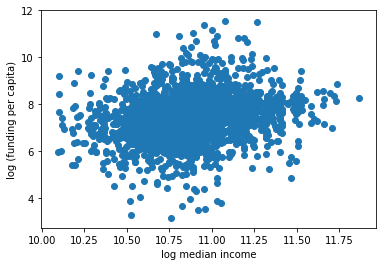

In [32]:
plt.scatter(data['log median income'], np.log(np.exp(data['log amount'])/np.exp(data['log population'])))
plt.xlabel("log median income")
plt.ylabel("log (funding per capita)")

In [40]:
diff1d= np.abs(np.subtract(yhat2, y)).reshape((yhat2.shape[0]))
model3 = linear_model.LinearRegression(normalize=True).fit(x_pop_inc, y, diff1d)

model3.coef_

array([[1.01351577, 0.82038614]])

In [45]:
from scipy.stats import pearsonr

pearsonr(data['log median income'], np.log(np.exp(data['log amount'])/np.exp(data['log population'])))

(0.19898556960958408, 6.970084914516602e-28)